In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.svm import SVC
import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score,classification_report,cohen_kappa_score
from sklearn.metrics import roc_curve,auc,precision_score,recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
from tqdm import tqdm_notebook
from IPython import display
import os
import glob
import warnings
warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
def moving_windows(X_test, X_train, y_test, y_train):
# function for move all windows from one recording to either training or testing set
    for k in range(np.max(X_test['flag'])):
        #print(k)
        samples_test = np.shape(X_test.loc[X_test['flag'].isin([k])])[0]
        samples_train = np.shape(X_train.loc[X_train['flag'].isin([k])])[0]
        if samples_test !=0 and samples_train != 0:
            size_nondrivers_train = np.shape(y_train.loc[y_train['target'].isin([0])])[0]
            size_drivers_train = np.shape(y_train.loc[y_train['target'].isin([1])])[0]
            size_nondrivers_test = np.shape(y_test.loc[y_test['target'].isin([0])])[0]
            size_drivers_test = np.shape(y_test.loc[y_test['target'].isin([1])])[0]
            percentage_drivers_test = size_drivers_test/ (size_drivers_test+size_nondrivers_test)
            percentage_drivers_train = size_drivers_train/ (size_drivers_train+size_nondrivers_train)
            target = int(y_test.loc[X_test.loc[X_test['flag'].isin([k])].index.values.astype(int)[0]])
            if ((target ==0) and (percentage_drivers_train > percentage_drivers_test)) or ((target ==1) and (percentage_drivers_train < percentage_drivers_test)):
                indexes_to_change = X_test.loc[X_test['flag'].isin([k])].index.values.astype(int)
                X_train = X_train.append(X_test.loc[X_test['flag'].isin([k])])
                y_train = y_train.append(y_test.loc[indexes_to_change])
                X_test.drop(indexes_to_change,0,inplace=True)
                y_test.drop(indexes_to_change,0,inplace=True)
            if (target ==0 and percentage_drivers_train < percentage_drivers_test) or (target ==1 and percentage_drivers_train > percentage_drivers_test):
                indexes_to_change = X_train.loc[X_train['flag'].isin([k])].index.values.astype(int)
                X_test = X_test.append(X_train.loc[X_train['flag'].isin([k])])
                y_test = y_test.append(y_train.loc[indexes_to_change])
                X_train.drop(indexes_to_change,0,inplace=True)
                y_train.drop(indexes_to_change,0,inplace=True)
    return X_test, X_train, y_test, y_train

def X_y_creation(data_with_noise,key):
    data = data_with_noise.loc[~data_with_noise['target'].isin([-1])]
    if key == 'core':
        data['target'] = data['target'].map({1: 1, 0: 0,0.5:0})
    if key == 'tail':
        data['target'] = data['target'].map({1: 1, 0: 0,0.5:1})
    X_target = data.drop(data.columns[:71], 1)
    X_old = data.drop(data.columns[35:], 1)
    X_new = pd.concat([X_old,X_target],axis=1) # single-electrode
    X_neighbour = data.drop(data.columns[:35], 1)
    X_neighbour = X_neighbour.drop('target', 1)
    #X_new = data.drop('target', 1)
    y = data.drop(data.columns[:70], 1)
    y = y.drop(y.columns[1:],1)
    (X_train_new, X_test_new, y_train_new, y_test_new) = train_test_split(X_new, y, test_size=0.3, stratify=y)
    X_test_new, X_train_new, y_test_new, y_train_new = moving_windows(X_test_new, X_train_new, y_test_new, y_train_new)
    X_test_new = X_test_new.drop('flag',1)
    X_train_new = X_train_new.drop('flag',1)
    encoder = StandardScaler()
    X_train_scaled_new = encoder.fit_transform(X_train_new)
    X_test_scaled_new = encoder.fit_transform(X_test_new)
    (X_train_neighbour, X_test_neighbour, y_train_neighbour, y_test_neighbour) = train_test_split(X_neighbour, y, test_size=0.3, stratify=y)
    X_test_neighbour, X_train_neighbour, y_test_neighbour, y_train_neighbour = moving_windows(X_test_neighbour, X_train_neighbour, y_test_neighbour, y_train_neighbour)
    X_test_neighbour_flag = X_test_neighbour
    X_test_neighbour = X_test_neighbour.drop('flag',1)
    X_train_neighbour = X_train_neighbour.drop('flag',1)
    encoder = StandardScaler()
    X_train_scaled_neighbour = encoder.fit_transform(X_train_neighbour)
    X_test_scaled_neighbour = encoder.fit_transform(X_test_neighbour)
    print("Data shape is",data.shape)
    return X_test_neighbour_flag, X_neighbour, X_new, y, X_train_new, X_test_new, y_train_new, y_test_new,X_train_neighbour, X_test_neighbour, y_train_neighbour, y_test_neighbour, X_train_scaled_new, X_test_scaled_new, X_train_scaled_neighbour, X_test_scaled_neighbour,y


def results(model, param_grid, cv, X_train,y_train, X_test, y_test):
    optimizer = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1,scoring='f1')
    optimizer.fit(X_train, y_train)

    y_proba = optimizer.best_estimator_.predict_proba(X_train) ###
    y_test1=y_train
    fpr, tpr, threshold = roc_curve(y_test1, y_proba[:,1])
    roc_auc1 = auc(fpr, tpr)
    roc_auc2 = roc_auc_score(y_test1, y_proba[:,1]) #change auc to roc_auc_score
    #roc_auc3 = roc_auc_score(y_test1, optimizer.best_estimator_.predict(X_train))
    plt.title('Receiver Operating Characteristic for train')
    plt.plot(fpr, tpr, 'b', label = 'AUC1 = %0.2f' % roc_auc1)
    #plt.plot(fpr, tpr, 'b', label = 'AUC2 = %0.2f' % roc_auc3)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    y_proba = optimizer.best_estimator_.predict_proba(X_test) ###
    fpr, tpr, threshold = roc_curve(y_test, y_proba[:,1])
    roc_auc1 = auc(fpr, tpr)
    roc_auc2 = roc_auc_score(y_test, optimizer.best_estimator_.predict_proba(X_test)[:,1]) #change auc to roc_auc_score
    #roc_auc3 = roc_auc_score(y_test, optimizer.best_estimator_.predict(X_test))
    plt.title('Receiver Operating Characteristic for test')
    plt.plot(fpr, tpr, 'b', label = 'AUC1 = %0.2f' % roc_auc1)
    #plt.plot(fpr, tpr, 'b', label = 'AUC2 = %0.2f' % roc_auc3)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    #plt.savefig('roc-auc AF MEM kNN.pdf')
    
    print("Model characteristics - ",optimizer.best_estimator_) 
    return optimizer,fpr,tpr,threshold


def results_full_test(optimizer, threshold, X_test_flag, y_test_flag):
    model = optimizer.best_estimator_

    (X0_50, X50_100, y0_50, y50_100) = train_test_split(X_test_flag, y_test_flag, test_size=0.5, stratify=y_test_neighbour)
    
    (X0_25, X25_50, y0_25, y25_50) = train_test_split(X0_50, y0_50, test_size=0.5, stratify=y0_50)
    (X50_75, X75_100, y50_75, y75_100) = train_test_split(X50_100, y50_100, test_size=0.5, stratify=y50_100)
    
    (X0_12, X12_25, y0_12, y12_25) = train_test_split(X0_25, y0_25, test_size=0.5, stratify=y0_25)
    (X25_37, X37_50, y25_37, y37_50) = train_test_split(X25_50, y25_50, test_size=0.5, stratify=y25_50)
    (X50_62, X62_75, y50_62, y62_75) = train_test_split(X50_75, y50_75, test_size=0.5, stratify=y50_75)
    (X75_87, X87_100, y75_87, y87_100) = train_test_split(X75_100, y75_100, test_size=0.5, stratify=y75_100)

    f1_list=[]
    acc_list=[]
    rec_list=[]
    prec_list =[]
    X= [X0_12,X12_25,X25_37, X37_50, X50_62,X62_75,X75_87, X87_100]
    y= [y0_12,y12_25,y25_37, y37_50, y50_62,y62_75,y75_87, y87_100]
    for X_test,y_test in zip(X,y):
        y_proba = model.predict_proba(X_test)
        y_pred = (y_proba [:,1] >= threshold).astype('int')
        acc= (accuracy_score(y_test, y_pred))
        prec=precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1=f1_score(y_test, y_pred)
        f1_list.append(f1)
        acc_list.append(acc)
        rec_list.append(rec)
        prec_list.append(prec)

    acc_mean = np.mean(acc_list)

    print("Model accuracy: mean %.3f, std %.3f" % (np.mean(acc_list), np.std(acc_list,ddof=1)))
    mean_std_acc_score = np.std(acc_list,ddof=1)/np.sqrt(len(acc_list))
    tconf_acc_score = _tconfint_generic(acc_mean, mean_std_acc_score, len(acc_list) - 1, 0.05, 'two-sided')
    print("Model accuracy 95%% confidence interval:", tconf_acc_score)

    precision_mean = np.mean(prec_list)
    print("Model precision: mean %.3f, std %.3f" % (np.mean(prec_list), np.std(prec_list,ddof=1)))
    mean_std_precision_score = np.std(prec_list,ddof=1)/np.sqrt(len(prec_list))
    tconf_precision_score = _tconfint_generic(precision_mean, mean_std_precision_score, len(prec_list) - 1, 0.05, 'two-sided')
    print("Model precision 95%% confidence interval:", tconf_precision_score)

    mean_recall_score = np.mean(rec_list)
    print("Model recall: mean %.3f, std %.3f" % (np.mean(rec_list), np.std(rec_list,ddof=1)))
    mean_std_recall_score = np.std(rec_list,ddof=1)/np.sqrt(len(rec_list))
    tconf_recall_score = _tconfint_generic(mean_recall_score, mean_std_recall_score, len(rec_list) - 1, 0.05, 'two-sided')
    print("Model recall 95%% confidence interval:", tconf_recall_score)

    mean_f1score = np.mean(f1_list)
    print("Model f1-score: mean %.3f, std %.3f" % (np.mean(f1_list), np.std(f1_list,ddof=1)))
    mean_std_f1score = np.std(f1_list,ddof=1)/np.sqrt(len(f1_list))
    tconf_f1score = _tconfint_generic(mean_f1score, mean_std_f1score, len(f1_list) - 1, 0.05, 'two-sided')
    print("Model f1-score 95%% confidence interval:", tconf_f1score)
 
    return acc_list, prec_list, rec_list, f1_list    

def evaluate_metric(model, x_cv, y_cv):
    return f1_score(y_cv, model.predict(x_cv))

def change_threshold(optimizer, X_test, y_test):
    y_proba = optimizer.best_estimator_.predict_proba(X_test)
    f1_memory=0
    for i in range(600):
        threshold = 0.2+i*0.001
        y_pred = (y_proba [:,1] >= threshold).astype('int')
        f1= f1_score(y_test, y_pred)
        if f1>f1_memory:
            f1_memory=f1
            threshold_memory=threshold
    print('f1=',f1_memory)
    print('threshold=',threshold_memory)
    return threshold_memory, optimizer.best_estimator_
def threshold(optimizer, X_test, y_test):
    y_proba = optimizer.best_estimator_.predict_proba(X_test)
    f1_list=[]
    threshold_list=[]
    prec_list=[]
    rec_list=[]
    for i in range(600):
        threshold = 0.2+i*0.001
        y_pred = (y_proba [:,1] >= threshold).astype('int')
        f1= f1_score(y_test, y_pred)
        prec=precision_score(y_test, y_pred)
        rec=recall_score(y_test, y_pred)
        threshold_list.append(threshold)
        f1_list.append(f1)
        prec_list.append(prec)
        rec_list.append(rec)
    plt.plot(threshold_list,f1_list,'b',label = 'f1')
    plt.plot(threshold_list,prec_list,'r',label = 'precision')
    plt.plot(threshold_list,rec_list,'g',label = 'recall')
    plt.legend(loc = 'lower right')
def results_with_changed_threshold(threshold, model, X_test, y_test):
    y_proba = model.predict_proba(X_test)
    y_pred = (y_proba [:,1] >= threshold).astype('int')
    acc= (accuracy_score(y_test, y_pred))
    print("Accuracy: %.2f%%" % (acc * 100.0))
    f1= f1_score(y_test, y_pred)
    print('f1=',f1)
    report = classification_report(y_test, y_pred)
    print(report)
    matrix = confusion_matrix(y_test, y_pred)
    print(matrix)
    cohen = cohen_kappa_score(y_test, y_pred)
    print('cohen_kappa=',cohen)


In [3]:
path = ''
data_with_noise = pd.read_csv(path + '\Feature matrix.csv', index_col=0)

In [4]:
X_test_neighbour_flag,X_neighbour, X_new, y, X_train_new, X_test_new, y_train_new, y_test_new,X_train_neighbour, X_test_neighbour, y_train_neighbour, y_test_neighbour, X_train_scaled_new, X_test_scaled_new, X_train_scaled_neighbour, X_test_scaled_neighbour,y = X_y_creation(data_with_noise,key = 'tail')

Data shape is (17875, 72)


### kNN

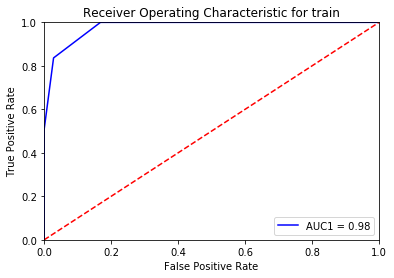

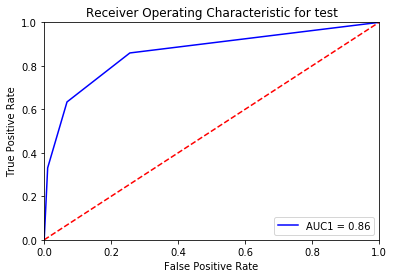

Model characteristics -  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')


In [5]:
model = KNeighborsClassifier()
cv=3
param_grid = {'n_neighbors': [3,4,5,6,7]}
optimizer,fpr,tpr,threshold = results(model, param_grid, cv, X_train_scaled_neighbour,y_train_neighbour, X_test_scaled_neighbour, y_test_neighbour)  

In [8]:
print("Train with 0.5 threshold")
results_with_changed_threshold(0.5, optimizer.best_estimator_, X_train_scaled_neighbour,y_train_neighbour)
print("Test with 0.5 threshold")
results_with_changed_threshold(0.5, optimizer.best_estimator_, X_test_scaled_neighbour, y_test_neighbour)  

Train with 0.5 threshold
Accuracy: 94.61%
f1= 0.8558461205964989
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     10008
           1       0.88      0.84      0.86      2367

    accuracy                           0.95     12375
   macro avg       0.92      0.90      0.91     12375
weighted avg       0.95      0.95      0.95     12375

[[9728  280]
 [ 387 1980]]
cohen_kappa= 0.822721768133507
Test with 0.5 threshold
Accuracy: 87.49%
f1= 0.6597428288822946
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      4448
           1       0.69      0.63      0.66      1052

    accuracy                           0.87      5500
   macro avg       0.80      0.78      0.79      5500
weighted avg       0.87      0.87      0.87      5500

[[4145  303]
 [ 385  667]]
cohen_kappa= 0.5832654193997436


In [9]:
acc_list, precision_list, recall_list, f1_list = results_full_test(optimizer, 0.5, X_test_scaled_neighbour, y_test_neighbour)

Model accuracy: mean 0.875, std 0.014
Model accuracy 95%% confidence interval: (0.8634095997753893, 0.886416383603643)
Model precision: mean 0.687, std 0.035
Model precision 95%% confidence interval: (0.6581633781222892, 0.7163692265457647)
Model recall: mean 0.634, std 0.048
Model recall 95%% confidence interval: (0.5936088325061749, 0.6745353960388168)
Model f1-score: mean 0.659, std 0.040
Model f1-score 95%% confidence interval: (0.625495743843129, 0.6931972421292947)


### Random Forest

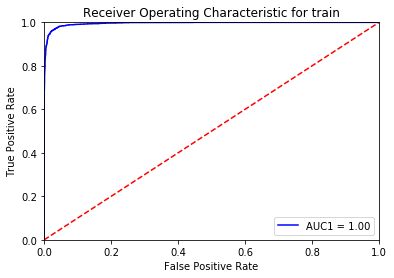

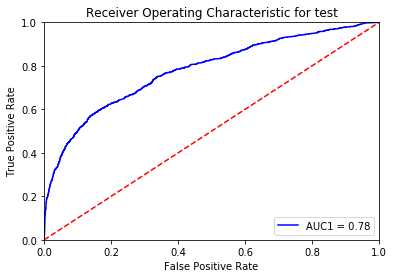

Model characteristics -  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [22]:
model = RandomForestClassifier(n_jobs=-1)
param_grid = {'n_estimators': np.arange(8,11,1),'max_depth': np.arange(10,15,1)}
optimizer,fpr,tpr,threshold = results(model, param_grid, cv, X_train_scaled_neighbour,y_train_neighbour, X_test_scaled_neighbour, y_test_neighbour)  

In [25]:
print("Train")
threshold_memory_train, optimizer.best_estimator_ = change_threshold(optimizer, X_train_scaled_neighbour,y_train_neighbour)
results_with_changed_threshold(threshold_memory_train, optimizer.best_estimator_, X_train_scaled_neighbour,y_train_neighbour)
print("Train with 0.5 threshold")
results_with_changed_threshold(0.5, optimizer.best_estimator_, X_train_scaled_neighbour,y_train_neighbour)
print("Test")
threshold_memory_test, optimizer.best_estimator_ = change_threshold(optimizer, X_test_scaled_neighbour, y_test_neighbour)
results_with_changed_threshold(threshold_memory_test, optimizer.best_estimator_, X_test_scaled_neighbour, y_test_neighbour)
print("Train with 0.5 threshold")
results_with_changed_threshold(0.5, optimizer.best_estimator_, X_test_scaled_neighbour, y_test_neighbour)
print("Test with train threshold")
results_with_changed_threshold(threshold_memory_train, optimizer.best_estimator_, X_test_scaled_neighbour, y_test_neighbour)   

Train
f1= 0.9437247823317052
threshold= 0.345
Accuracy: 97.86%
f1= 0.9437247823317052
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10008
           1       0.95      0.94      0.94      2367

    accuracy                           0.98     12375
   macro avg       0.97      0.96      0.97     12375
weighted avg       0.98      0.98      0.98     12375

[[9888  120]
 [ 145 2222]]
cohen_kappa= 0.9305023495212553
Train with 0.5 threshold
Accuracy: 95.11%
f1= 0.8542519874728981
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10008
           1       0.99      0.75      0.85      2367

    accuracy                           0.95     12375
   macro avg       0.97      0.87      0.91     12375
weighted avg       0.95      0.95      0.95     12375

[[9997   11]
 [ 594 1773]]
cohen_kappa= 0.8255749709440139
Test
f1= 0.5295169946332737
threshold= 0.347
Accuracy: 80.87%
f1= 0.529516994

In [26]:
#result with test threshold
acc_list, precision_list, recall_list, f1_list = results_full_test(optimizer, threshold_memory_test, X_test_scaled_neighbour, y_test_neighbour)
print("    ")
#result with train threshold
acc_list, precision_list, recall_list, f1_list = results_full_test(optimizer, threshold_memory_train, X_test_scaled_neighbour, y_test_neighbour)

Model accuracy: mean 0.809, std 0.008
Model accuracy 95%% confidence interval: (0.8016348340130651, 0.8158221537327796)
Model precision: mean 0.500, std 0.020
Model precision 95%% confidence interval: (0.48399513398066796, 0.516717143184018)
Model recall: mean 0.563, std 0.037
Model recall 95%% confidence interval: (0.5314842572067365, 0.5940795873456578)
Model f1-score: mean 0.529, std 0.023
Model f1-score 95%% confidence interval: (0.5103052789959595, 0.5481026542940948)
    
Model accuracy: mean 0.807, std 0.011
Model accuracy 95%% confidence interval: (0.7981644328267696, 0.8160259085631629)
Model precision: mean 0.498, std 0.024
Model precision 95%% confidence interval: (0.4776240755123797, 0.5178258118664952)
Model recall: mean 0.565, std 0.021
Model recall 95%% confidence interval: (0.5471637774937423, 0.5820867429781522)
Model f1-score: mean 0.528, std 0.011
Model f1-score 95%% confidence interval: (0.5191783015416127, 0.5376367110631779)
